This notebook provides an analysisi of the "ISAN" network on a parenthesis counting task. For more explanation, please see https://arxiv.org/abs/1611.09434.


Please note that this notebok requires a nightly build of tensorflow (it uses some of the upcoming V1.0 API). To run it, please install the latest build running:
`pip install https://ci.tensorflow.org/view/Nightly/job/nightly-matrix-linux-gpu/TF_BUILD_IS_OPT=OPT,TF_BUILD_IS_PIP=PIP,TF_BUILD_PYTHON_VERSION=PYTHON2,label=gpu-linux/lastSuccessfulBuild/artifact/pip_test/whl/tensorflow_gpu-0.12.1-cp27-none-linux_x86_64.whl`

In [27]:
%matplotlib inline

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from matplotlib import pyplot as plt

import numpy as np
import scipy.linalg

import seaborn as sns
import tensorflow as tf


In [2]:
tf.__version__

'0.12.head'

In [3]:
def isan_cell(step_inputs, state, initialization="orthogonal"):
  """
  Make one step of ISAN transition. 
  
  Args:
    step_inputs: one-hot encoded inputs, shape bs x n
    state: previous hidden state, shape bs x d
    initialization: how to initialize the transition matrices:
      orthogonal: usually speeds up training, orthogonalize Gaussian matrices
      gaussian: sample gaussian matrices with a sensible scale
    
  """
  
  bs, d = state.get_shape().as_list()
  n = step_inputs.shape[1].value
  
  with tf.variable_scope('isan_cell', values=[step_inputs, state]) as sc:
    
    if initialization == "orthogonal":
      Wx_ndd_init = np.zeros((n, d*d), dtype=np.float32)
      for i in range(n):
        Wx_ndd_init[i, :] = scipy.linalg.orth(
            np.random.randn(d, d)).astype(np.float32).ravel()
      Wx_ndd_initializer = tf.constant_initializer(Wx_ndd_init)
    elif initialization == "gaussian":
      Wx_ndd_initializer = tf.random_normal_initializer(stdev = 1.0/np.sqrt(d))
    else:
      raise Exception("Unknown init type: %s" % (initialization))
    
    
    Wx_ndd = tf.get_variable('Wx', shape=[n, d*d],
                            initializer=Wx_ndd_initializer)
    bx_nd = tf.get_variable('bx', shape=[n, d], 
                            initializer=tf.zeros_initializer())
    
    # Multiplication with a 1-hot is just row selection.
    # As of Jan '17 this is faster than doing gather.
    Wx_bdd = tf.reshape(tf.matmul(step_inputs, Wx_ndd), [bs, d, d])
    bx_bd = tf.reshape(tf.matmul(step_inputs, bx_nd), [bs, 1, d])
    
    # Reshape the state so that matmul multiplies different matrices
    # for each batch element.
    state = tf.reshape(state, [bs, 1, d])
    new_state = tf.reshape(tf.matmul(state, Wx_bdd) + bx_bd, [bs, d])
  return new_state


def isan_rnn(inputs, n_tokens, dim):
  """
  Unroll in time the ISAN cell.
  
  Args:
    inputs: t x bs int32 array of token ids over t timesteps
    n_tokens: maximal token id seen on input
    
  Returns:
    t x bs x d tensor of states of the ISAN cell
  """
  one_hot_inputs = tf.one_hot(inputs, n_tokens, axis=-1)
  num_steps, bs = inputs.get_shape().as_list()
  with tf.variable_scope("rnn", values=[inputs]) as sc:
    h0 = tf.get_variable("h0", shape=[1, dim],
                         initializer=tf.zeros_initializer())
    state = tf.tile(h0, [bs, 1])
    step_states = []
    for step_inputs in tf.unstack(one_hot_inputs):
      state = isan_cell(step_inputs, state)
      step_states.append(state)
      sc.reuse_variables()
  return tf.stack(step_states)


class ISAN(object):
  def __init__(self, n_tokens, hidden_dim, target_dim):
    self.n_tokens = n_tokens
    self.hidden_dim = hidden_dim
    self.target_dim = target_dim
  
  def fprop(self, inputs):
    with tf.variable_scope("model", values=[inputs]):
      states = isan_rnn(inputs, self.n_tokens, self.hidden_dim)
      Wo = tf.get_variable("Wo", shape=[self.hidden_dim, self.target_dim],
                          initializer=tf.random_normal_initializer(
                              stddev=1.0/(self.hidden_dim + self.target_dim)**2))
      bo = tf.get_variable("bo", shape=[1, self.target_dim],
                          initializer=tf.zeros_initializer())

      t, bs = inputs.get_shape().as_list()
      logits = tf.matmul(tf.reshape(states, [t * bs, self.hidden_dim]), Wo) + bo
      logits = tf.reshape(logits, [t, bs, self.target_dim])
    return logits

class ParenthesisTask(object):
  def __init__(self, max_count=5, implied_activation_fn="softmax"):
    """
    Saturating count number of non-closed parenthesis.
    
    Args:
      max_count: level at which outstanding opening parenthesis stop being added
      implied_activation_fn: how is the output of the netowkr interpreted:
        - softmax: treat it as logits, train via neg-log likelihood minimization
        - identity: treat it as probabilites, train via least-squares
    """
    self.max_count = max_count
    self.implied_activation_fn = implied_activation_fn
    self.parens = "()[]{}"
    self.n_paren_types = len(self.parens) // 2
    self.noises = "a"
    
    self.id_to_token = self.parens + self.noises
    self.token_to_id = {t:i for i,t in enumerate(self.id_to_token)}
    
    self.n_tokens = len(self.id_to_token)
    self.n_outputs = self.n_paren_types * (self.max_count + 1)
    
  def sample_batch(self, t, bs):
    inputs = (np.random.rand(t, bs)* len(self.id_to_token)).astype(np.int32)
    counts = np.zeros((bs, self.n_paren_types), dtype=np.int32)
    targets = np.zeros((t, bs, self.n_paren_types), dtype = np.int32)
    opening_parens = (np.arange(0, self.n_paren_types)*2)[None, :]
    closing_parens = opening_parens + 1
    for i in range(t):
      opened = np.equal(inputs[i, :, None], opening_parens)
      counts = np.minimum(self.max_count, counts + opened)
      closed = np.equal(inputs[i, :, None], closing_parens)
      counts = np.maximum(0, counts - closed)
      targets[i, :, :] = counts
    return inputs, targets
  
  def  loss(self, logits, targets):
    bs, t, _ = logits.get_shape().as_list()
    logits = tf.reshape(logits, (bs, t, self.n_paren_types, self.max_count + 1))
        
    if self.implied_activation_fn == "softmax":
      loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits, targets)
    elif self.implied_activation_fn == "identity":
      loss = tf.square(logits - tf.one_hot(targets, self.max_count + 1))
    else:
      raise
    
    return tf.reduce_mean(loss)
  
  def print_batch(self, inputs, targets, predictions=None, max_to_print=1):
    if predictions is not None:
      predictions = np.reshape(
          predictions, 
          predictions.shape[:2] + (self.n_paren_types, self.max_count + 1))
    for i in range(min(max_to_print, inputs.shape[1])):
      print("%3d:" %(i,), " ".join([self.id_to_token[t] for t in inputs[:, i]]))
      for paren_kind in range(self.n_paren_types):
        print("G%s:" % self.parens[2*paren_kind:2*paren_kind+2], 
              " ".join([str(c) for c in targets[:, i, paren_kind]]))
        if predictions is not None:
          pred = np.argmax(predictions[:,i, paren_kind], axis=1)
          print("P%s:" % self.parens[2*paren_kind:2*paren_kind+2], 
                " ".join([str(c) for c in pred]))
 

In [4]:
# Training configuration

MAX_COUNT = 5
HIDDEN_DIM = 50 # will work nicely if set to 2*(MAX_COUNT + 1)
N_TRAIN_STEPS = 20000
BATCH_SIZE = 16
T = 100
WEIGHT_DECAY = 1e-4


In [5]:
task = ParenthesisTask(max_count=MAX_COUNT, 
                       #implied_activation_fn="softmax")
                       implied_activation_fn="identity")
task.print_batch(*task.sample_batch(100, 2))

  0: ( ( } } ( ( } { ) ) ( [ ] a } ( ) ) a ] ) ) ) { a ) } ( ) a ( ] [ a { [ } ( a ( { a } } [ } } [ ) [ ) } ) ] ( { ] ( ) a } a a ) { [ { ) ) ) a a ) { } } ( ] ) a } ( a ( a { ] { ] { } } { { { { { ) { (
G(): 1 2 2 2 3 4 4 4 3 2 3 3 3 3 3 4 3 2 2 2 1 0 0 0 0 0 0 1 0 0 1 1 1 1 1 1 1 2 2 3 3 3 3 3 3 3 3 3 2 2 1 1 0 0 1 1 1 2 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 2
G[]: 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 2 2 2 2 2 2 2 2 3 3 3 4 4 5 5 5 5 4 4 4 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 3 3 3 3 3 3 3 3 3 2 2 1 1 1 1 1 1 1 1 1 1 1 1
G{}: 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 1 1 2 2 2 2 2 2 2 3 2 1 1 1 1 1 0 0 0 0 0 1 1 2 2 3 2 1 2 3 4 5 5 5 5 5


In [6]:
tf.reset_default_graph()

with tf.variable_scope("model"):
  model = ISAN(task.n_tokens, HIDDEN_DIM, task.n_outputs)

  inputs = tf.placeholder(tf.int32, shape=(T, BATCH_SIZE), name="inputs")
  targets = tf.placeholder(tf.int32, shape=(T, BATCH_SIZE, task.n_paren_types), 
                           name="targets")

  logits = model.fprop(inputs)

  task_loss = task.loss(logits, targets)
  weight_loss = 0.0
  for v in tf.trainable_variables():
    if v.name.split('/')[-1].startswith('W'):
      weight_loss = weight_loss + WEIGHT_DECAY * tf.nn.l2_loss(v)
      
  loss = task_loss + weight_loss

learning_rate = tf.placeholder(tf.float32, shape=(), name="learning_rate")

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss)

tf.get_variable_scope().reuse_variables()

In [7]:
inputs.get_shape().as_list()

[100, 16]

In [8]:
print ("Training the following variables:")
for v in tf.trainable_variables():
  print ("%s: %s (%s)" % (v.name, v.get_shape().as_list(), 
                          v.initializer.inputs[1].op.name))

Training the following variables:
model/model/rnn/h0:0: [1, 50] (model/model/rnn/h0/Initializer/Const)
model/model/rnn/isan_cell/Wx:0: [7, 2500] (model/model/rnn/isan_cell/Wx/Initializer/Const)
model/model/rnn/isan_cell/bx:0: [7, 50] (model/model/rnn/isan_cell/bx/Initializer/Const)
model/model/Wo:0: [50, 18] (model/model/Wo/Initializer/random_normal)
model/model/bo:0: [1, 18] (model/model/bo/Initializer/Const)


In [9]:
sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())

PRINT_PERIOD = 500

task_loss_acc = 0


for i in range(N_TRAIN_STEPS):
  v_inputs, v_targets = task.sample_batch(T, BATCH_SIZE)
  feed_dict = {inputs:v_inputs, 
               targets:v_targets,
               #learning_rate:min(1e-4, 1e-4 * 1000/(i+1))
               learning_rate:2e-4
              }
  v_task_loss, v_logits, _ = sess.run([task_loss, logits, train_op], feed_dict=feed_dict)
  
  task_loss_acc += v_task_loss
  
  if ((i + 1) % PRINT_PERIOD) == 0:
    print("Step %d loss %f" % (i, task_loss_acc / PRINT_PERIOD))
    task.print_batch(v_inputs, v_targets, v_logits)
    print("")
    task_loss_acc = 0


Instructions for updating:
Use `tf.global_variables_initializer` instead.
Step 499 loss 0.136900
  0: ) [ } [ ) [ ( { ( { [ } } ] { ( } [ ( } ] } a ( { { ] [ [ [ ( a a a a } ) { a { } { a ( { } { ( [ ) { ( } ( } a { a { ) { { } a { [ ( } a ) ] a [ ) ( { a [ a { ( a ] a ( [ ( { ) [ ( ) a ] a ] { [ { [
G(): 0 0 0 0 0 0 1 1 2 2 2 2 2 2 2 3 3 3 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 4 4 4 4 4 4 4 5 5 5 5 5 5 4 4 5 5 5 5 5 5 5 5 4 4 4 4 4 4 4 5 5 5 4 4 4 4 3 4 4 4 4 4 4 5 5 5 5 5 5 5 5 4 4 5 4 4 4 4 4 4 4 4 4
P(): 0 0 0 0 0 0 1 0 1 1 1 0 0 0 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0 0 0 1 0 1 1 0 0 1 1 0 0 1 1 1 1 1 1 1 0 0 0 0 1 0 0 0 1 1 1 0 0 0 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 0 0 0 0 0 0 1 0 0
G[]: 0 1 1 2 2 3 3 3 3 3 4 4 4 3 3 3 3 4 4 4 3 3 3 3 3 3 2 3 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 4 4 5 5 5 5 5 5 5 5 5 5 4 4 4 5 5 5 5 5 5 5 5 4 4 3 3 4 4 5
P[]: 0 1 1 5 1 5 1 1 1 1 5 1 1 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 2 5 2 1 2 2 2 1 1 0 1 

KeyboardInterrupt: 

In [19]:
def fetch_val(sess, name):
  for v in tf.trainable_variables():
    if v.name.startswith(name):
      return sess.run(v)
  raise KeyError()

In [20]:
bo = fetch_val(sess, "model/model/bo")
Wo = fetch_val(sess, "model/model/Wo")

bx = fetch_val(sess, "model/model/rnn/isan_cell/bx")
Wx = fetch_val(sess, "model/model/rnn/isan_cell/Wx"
              ).reshape(bx.shape[0], bx.shape[1], bx.shape[1])

h0 = fetch_val(sess, "model/model/rnn/h0")

for vname in ["Wo", "bo", "Wx", "bx", "h0"]:
  print("Loaded %s with shape %s" % (vname, globals()[vname].shape))
  
S = task.token_to_id
print("Symbol dict is:", S)

Loaded Wo with shape (50, 18)
Loaded bo with shape (1, 18)
Loaded Wx with shape (7, 50, 50)
Loaded bx with shape (7, 50)
Loaded h0 with shape (1, 50)
Symbol dict is: {'a': 6, ')': 1, '(': 0, ']': 3, '[': 2, '}': 5, '{': 4}


In [21]:
# Let's check if the loaded parameters work

def simulate(paren_string):
  h = h0
  states = []
  for c in paren_string:
    h = h.dot(Wx[S[c]]) + bx[S[c]]
    states.append(h)
  states = np.concatenate(states, axis=0)
  return states, states.dot(Wo) + bo

paren_string = "(((((([)))))))))]{{{}"

v_states, v_logits = simulate(paren_string)

for p, c in zip(paren_string,
                np.argmax(v_logits.reshape(
                    v_logits.shape[0], task.n_paren_types, -1), axis=2)):
  print("%s: %s" % (p, c))


(: [1 0 0]
(: [2 0 0]
(: [3 0 0]
(: [4 0 0]
(: [5 0 0]
(: [5 0 0]
[: [5 1 0]
): [4 1 0]
): [3 1 0]
): [2 1 0]
): [1 1 0]
): [0 1 0]
): [0 1 0]
): [0 1 0]
): [0 1 0]
): [0 1 0]
]: [0 0 0]
{: [0 0 1]
{: [0 0 2]
{: [0 0 3]
}: [0 0 2]


In [22]:
# merge the biases into transition and readout matrices
# in this extended basis the model realizes switched linear dynamics
e_h0 = np.hstack((h0, [[1]]))
e_Wo = np.vstack((Wo, bo))
e_Wx = np.zeros((Wx.shape[0], Wx.shape[1]+1, Wx.shape[1]+1), Wx.dtype)

e_Wx[:, :-1, :-1] = Wx
e_Wx[:, -1, :-1] = bx[:, :]
e_Wx[:, -1, -1] = 1.0

def e_simulate(paren_string):
  h = e_h0
  states = []
  for c in paren_string:
    h = h.dot(e_Wx[S[c]])
    states.append(h)
  states = np.concatenate(states, axis=0)
  return states, states.dot(e_Wo)

v_states, v_logits = simulate(paren_string)
e_v_states, e_v_logits = e_simulate(paren_string)

assert np.allclose(e_v_logits, v_logits, atol=1e-5)
assert np.allclose(e_v_states[:,:-1], v_states, atol=1e-5)
assert np.allclose(e_v_states[:, -1], np.ones_like(e_v_states[:, -1]))

In [24]:
#
# Below we split the transition matrices into a readout part and a computational part
#
#


def get_orth_complement(V, W):
  """
  Find an orthonormal basis for span(V) and span(W).
  
  Args:
    V: matrix of shape k * n
    W: matrix of shape (n-k) * n
    
  Returns:
    Pair of matrices:
      V_orth: matrix of shape k * n
      W_orth: matrix of shape (n-k) * n

    such that the union of rows of V_orth and W_orth is an orthonormal basis
    for R^n
  
  """
  assert V.shape[0] + W.shape[0] == V.shape[1] == W.shape[1]
  V_orth = scipy.linalg.orth(V.T).T
  coeffs = V_orth.dot(W.T) #coeffs_ij = <V_orth_i, W_j>
  W_orth = W.copy()
  for j in xrange(len(W)):
    W_proj = np.sum(np.array([V_orth[i]*coeffs[i][j] for i in xrange(len(V_orth))]),axis=0)
    W_orth[j]-=W_proj
    
  W_orth = scipy.linalg.orth(W_orth.T).T
  
  return V_orth, W_orth

In [25]:
e_V_orth, e_W_orth = get_orth_complement(
    e_Wo.T, np.eye(e_Wo.shape[0]-e_Wo.shape[1], e_Wo.shape[0]))

basis_change = np.hstack((e_Wo, e_W_orth.T))

In [26]:
plt.figure(figsize=(10,5))

paren_string = "((aa))[][][]a([[[[[)))"

e_v_states, _ = e_simulate(paren_string)

plt.subplot(1, 2, 1)
plt.title("First %d dimensions aligned with output" % (e_Wo.shape[1]))

plt.imshow(e_v_states.dot(basis_change), interpolation='nearest', cmap='jet')
plt.axis('tight')
plt.vlines(e_Wo.shape[1]-0.5, *plt.ylim(), color='w')
plt.colorbar()

plt.yticks(*zip(*enumerate(paren_string)))
plt.ylabel("time")

plt.xlabel("Hidden dimension")

plt.grid(False)


plt.subplot(1, 2, 2)
plt.title("Original basis")
plt.imshow(e_v_states, interpolation='nearest', cmap='jet')
plt.axis('tight')
plt.colorbar()

plt.yticks(*zip(*enumerate(paren_string)))
plt.ylabel("time")

plt.xlabel("Hidden dimension")


plt.grid(False)


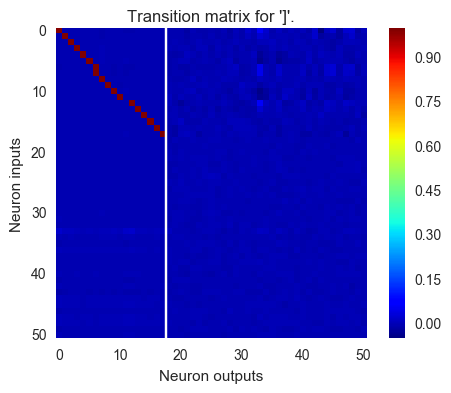

In [28]:
TOKEN = ']'
# First express e_Wx in the new basis:
basis_aligned_Wx = np.linalg.inv(basis_change
                                ).dot(e_Wx[S[TOKEN]]).dot(basis_change)

# Our model has an extra degree of freedom: the first dimensions of the hidden 
# state have exactly two elements equal to 1. We will subtract their influence

block_size = task.max_count+1
for p in range(task.n_paren_types):
  basis_aligned_Wx[p*block_size:(p+1)*block_size, :] -= np.median(
      basis_aligned_Wx[p*block_size:(p+1)*block_size, :], axis=0, keepdims=True)

plt.imshow(basis_aligned_Wx, 
           interpolation='nearest', cmap='jet')
plt.grid(False)
plt.vlines(e_Wo.shape[1]-0.5, *plt.ylim(), color='w')

plt.title("Transition matrix for '%s'." % (TOKEN,))
plt.xlabel("Neuron outputs")
plt.ylabel("Neuron inputs")
plt.colorbar()

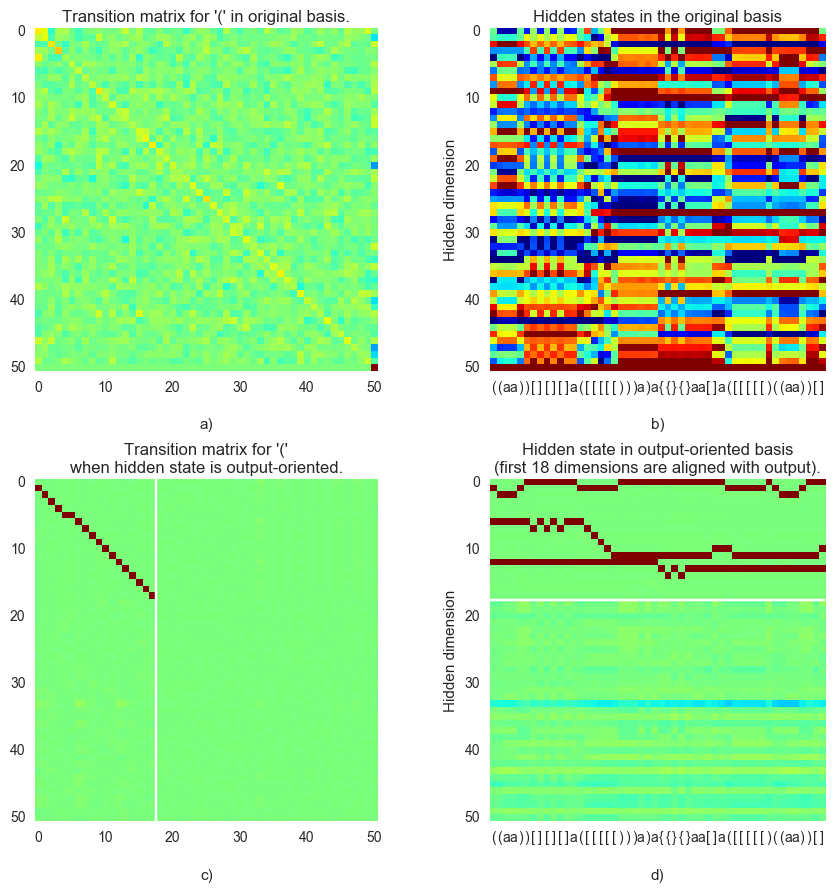

In [29]:
#
# This plot is a recreation of Fig. 10 from the paper - all matrices are transposed with the respect
# to the convention used in the code above.
#

paren_string = "((aa))[][][]a([[[[[)))a)a{{}{}aa[]a([[[[[)((aa))[][][]a([[[[[)))a)a(a[])aa[]a([[[[[)"[:50]

e_v_states, _ = e_simulate(paren_string)


TOKEN = '('
# First express e_Wx in the new basis:
basis_aligned_Wx = np.linalg.inv(basis_change
                                ).dot(e_Wx[S[TOKEN]]).dot(basis_change)

# Our model has an extra degree of freedom: the first dimensions of the hidden 
# state have exactly n_paren_types elements equal to 1. Here we will subtract
# their influence

block_size = task.max_count+1
for p in range(task.n_paren_types):
  basis_aligned_Wx[p*block_size:(p+1)*block_size, :] -= np.median(
      basis_aligned_Wx[p*block_size:(p+1)*block_size, :], axis=0, keepdims=True)


plt.figure(figsize=(9,9))

plt.subplot(221)


plt.imshow(e_Wx[S[TOKEN]].T, 
           interpolation='nearest', cmap='jet', vmin=-1, vmax=1)
plt.grid(False)

plt.title("Transition matrix for '%s' in original basis." % (TOKEN,))
#plt.colorbar()

plt.xlabel(" \na)")

plt.subplot(222)

plt.title("Hidden states in the original basis")

plt.imshow(e_v_states.T,
           interpolation='nearest', cmap='jet', vmin=-1, vmax=1)
#plt.axis('equal')
#plt.colorbar()

plt.xticks(*zip(*enumerate(paren_string)))
plt.xlabel("\nb)")

plt.ylabel("Hidden dimension")

plt.grid(False)

plt.subplot(223)


plt.imshow(basis_aligned_Wx.T, 
           interpolation='nearest', cmap='jet', vmin=-1, vmax=1)
plt.grid(False)
plt.vlines(e_Wo.shape[1]-0.5, *plt.ylim(), color='w')

plt.title("Transition matrix for '%s'\nwhen hidden state is output-oriented." % (TOKEN,))
#plt.colorbar()

plt.xlabel(" \nc)")

plt.subplot(224) #, sharex=plt.gca(), sharey=plt.gca())

plt.title("Hidden state in output-oriented basis\n(first %d dimensions are aligned with output)." % (e_Wo.shape[1]))

plt.imshow(e_v_states.dot(basis_change).T,
           interpolation='nearest', cmap='jet', vmin=-1, vmax=1)
#plt.axis('equal')
plt.hlines(e_Wo.shape[1]-0.5, *plt.xlim(), color='w')
#plt.colorbar()

plt.xticks(*zip(*enumerate(paren_string)))
plt.xlabel("\nd)")

plt.ylabel("Hidden dimension")

plt.grid(False)



plt.tight_layout()

plt.savefig("/tmp/fig.pdf", dpi=300)